![Facial Recognition](facialrecognition.jpg)

You are a member of an elite group of data scientists, specialising in advanced facial recognition technology, this firm is dedicated to identifying and safeguarding prominent individuals from various spheres—ranging from entertainment and sports to politics and philanthropy. The team's mission is to deploy AI-driven solutions that can accurately distinguish between images of notable personalities and the general populace, enhancing the personal security of such high-profile individuals. You're to focus on Arnold Schwarzenegger, a figure whose accomplishments span from bodybuilding champion to Hollywood icon, and from philanthropist to the Governor of California. 

### **The Data**
The `data/lfw_arnie_nonarnie.csv` dataset contains processed facial image data derived from the "Labeled Faces in the Wild" (LFW) dataset, focusing specifically on images of Arnold Schwarzenegger and other individuals not identified as him. This dataset has been prepared to aid in the development and evaluation of facial recognition models. There are 40 images of Arnold Schwarzenegger and 150 of other people.

| Column Name | Description |
|-------------|-------------|
| PC1, PC2, ... PCN | Principal components from PCA, capturing key image features. |
| Label | Binary indicator: `1` for Arnold Schwarzenegger, `0` for others. |

In [47]:
# Libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file 
df = pd.read_csv("data/lfw_arnie_nonarnie.csv")
print(df.head())
print(f"Shape of the data:{df.shape}")

          0         1         2         3  ...       147       148       149  Label
0 -2.061987  0.581320 -0.249115 -0.631340  ... -0.068297  0.022038  0.090003      1
1 -0.796838 -0.667228 -0.107889  0.019755  ... -0.089117  0.023588 -0.019998      1
2  5.376779  1.142695  2.543111 -2.727212  ... -0.118262  0.045881 -0.190158      1
3  7.029235  1.242883 -2.628079  1.224479  ... -0.125893  0.146396  0.013320      1
4  5.484822  6.752706 -4.291114  1.740412  ... -0.216803  0.025849  0.020456      1

[5 rows x 151 columns]
Shape of the data:(190, 151)


In [48]:
# Libs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

random_state_ = 124

# Separate the predictor and label
X = df.drop('Label', axis=1)
y = df['Label'] 

# Split the data into training and testing sets using stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=random_state_, 
    stratify=y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_)

In [49]:
def scoring_fun(model, X_test, y_test, model_name:str, scoring:str = 'f1'):
    
    """Prints the different scores for the model, and checks the fit."""
    
    y_pred  = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mtx = confusion_matrix(y_test, y_pred)
    
    # 1. Scores for test data
    print(f"The results of the {model_name} model:\n")
    print(f"accuracy:{accuracy}\n")
    print(f"precision:{precision}\n")
    print(f"recall:{recall}\n")
    print(f"f1:{f1 }\n")
    print(f"confusion_mtx:\n{confusion_mtx}\n")
    
    # 2. CV score
    print(f"Best CV Score: {model.best_score_:.4f}")
    
    # 3. checking fit (only for specific scorings[f1, accuracy])
    compare = False
    if scoring == 'f1':
        gap = model.best_score_ - f1
        compare=True
    elif scoring == 'accuracy':
        gap = model.best_score_ - accuracy
        compare=True
    else:
        print('Warning: cannot check overfitting if the scoring is not f1 or accuracy!')
        
    if compare:
        print(f"CV vs Test Gap: {gap:.4f}")
        if gap > 0.1:
            print('*'*60)
            print("Warning: Possible overfitting!")
            print('*'*60)
        elif gap < -0.05:
            print('*'*60)
            print("Warning: Test score higher than CV - check for data leakage!")
            print('*'*60)
            
    return accuracy, precision, recall, f1, confusion_mtx

In [50]:
# Libs
from sklearn.base import BaseEstimator, ClassifierMixin

# for adjusting the threshold of different models
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, threshold=0.5):
        self.estimator = estimator
        self.threshold = threshold
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def predict(self, X):
        y_proba = self.estimator.predict_proba(X)[:, 1]
        return (y_proba >= self.threshold).astype(int)

In [51]:
# Libs
from sklearn.linear_model import LogisticRegression

# Setting up and fitting a Logistic regression model
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

pipe_lr = ThresholdClassifier(pipe_lr, threshold=0.5)

params = {
    'estimator__lr__C': np.logspace(-4, 4, 40),
    'estimator__lr__penalty': ['l1','l2'],
    'estimator__lr__solver': ['saga'],
    'estimator__lr__class_weight': ['balanced', 'None'],
    'estimator__lr__random_state':[random_state_],
    'threshold':[0.2,0.3,0.4,0.5]
}

grid_lr = GridSearchCV(
    pipe_lr, 
    params, 
    cv=kf, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_lr = grid_lr.fit(X_train, y_train)

lr_results = scoring_fun(grid_lr, X_test, y_test, 'LogisticRegression', scoring='accuracy')

The results of the LogisticRegression model:

accuracy:0.8421052631578947

precision:1.0

recall:0.25

f1:0.4

confusion_mtx:
[[30  0]
 [ 6  2]]

Best CV Score: 0.8226
CV vs Test Gap: -0.0195


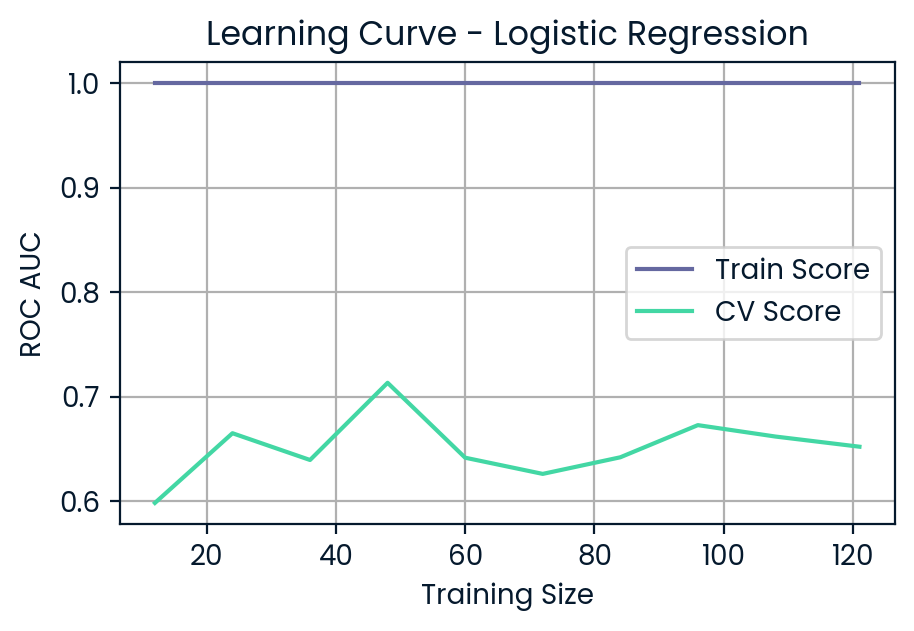

In [52]:
# Libs
from sklearn.model_selection import learning_curve

# Looking at the fitting curve for LogisticRegression
base_estimator = grid_lr.best_estimator_.estimator
train_sizes, train_scores, val_scores = learning_curve(
    base_estimator, 
    X_train, 
    y_train, 
    cv=kf, 
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(5, 3))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='CV Score')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC')
plt.title('Learning Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()

In [53]:
# Libs
from sklearn.neighbors import KNeighborsClassifier

# Setting up and fitting a K-Neighbors Classifier
pipe_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_KNN = ThresholdClassifier(pipe_KNN, threshold=0.5)

params = {
    'estimator__knn__n_neighbors' : np.arange(1,31,2),
    'estimator__knn__weights' : ['uniform', 'distance'],
    'estimator__knn__metric' : ['minkowski'],
    'estimator__knn__p': [1, 2],
    'estimator__knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'threshold':[0.2,0.3,0.4,0.5]
}

grid_knn = GridSearchCV(
    pipe_KNN, 
    params, 
    cv=kf, 
    scoring='f1',
    n_jobs=-1
)

grid_knn = grid_knn.fit(X_train, y_train)

knn_results = scoring_fun(grid_knn, X_test, y_test, 'KNeighborsClassifier')

The results of the KNeighborsClassifier model:

accuracy:0.7105263157894737

precision:0.38461538461538464

recall:0.625

f1:0.4761904761904762

confusion_mtx:
[[22  8]
 [ 3  5]]

Best CV Score: 0.4419
CV vs Test Gap: -0.0343


In [57]:
# Libs
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Setting up and fitting a RandomForest Classifier
pipe_rf = ImbPipeline([
    ('smote', SMOTE(random_state=random_state_, k_neighbors=2)),
    ('rf', RandomForestClassifier()),
])

pipe_rf = ThresholdClassifier(pipe_rf, threshold=0.5)

params = {
    'estimator__rf__n_estimators': [50, 100], 
    'estimator__rf__max_depth': [3, 5, 7],  
    'estimator__rf__min_samples_split': [5, 10],
    'estimator__rf__min_samples_leaf': [2, 4],
    'estimator__rf__class_weight': ['balanced', 'None'],
    'estimator__rf__random_state': [random_state_],
    'threshold':[0.2,0.3,0.4,0.5]
}

grid_rf = GridSearchCV(
    pipe_rf, 
    params, 
    cv=kf, 
    scoring='f1',
    n_jobs=-1
)

grid_rf = grid_rf.fit(X_train, y_train)

rf_results = scoring_fun(grid_rf, X_test, y_test, 'RandomForest', 'f1')

The results of the RandomForest model:

accuracy:0.7631578947368421

precision:0.42857142857142855

recall:0.375

f1:0.39999999999999997

confusion_mtx:
[[26  4]
 [ 5  3]]

Best CV Score: 0.5302
CV vs Test Gap: 0.1302
************************************************************
************************************************************


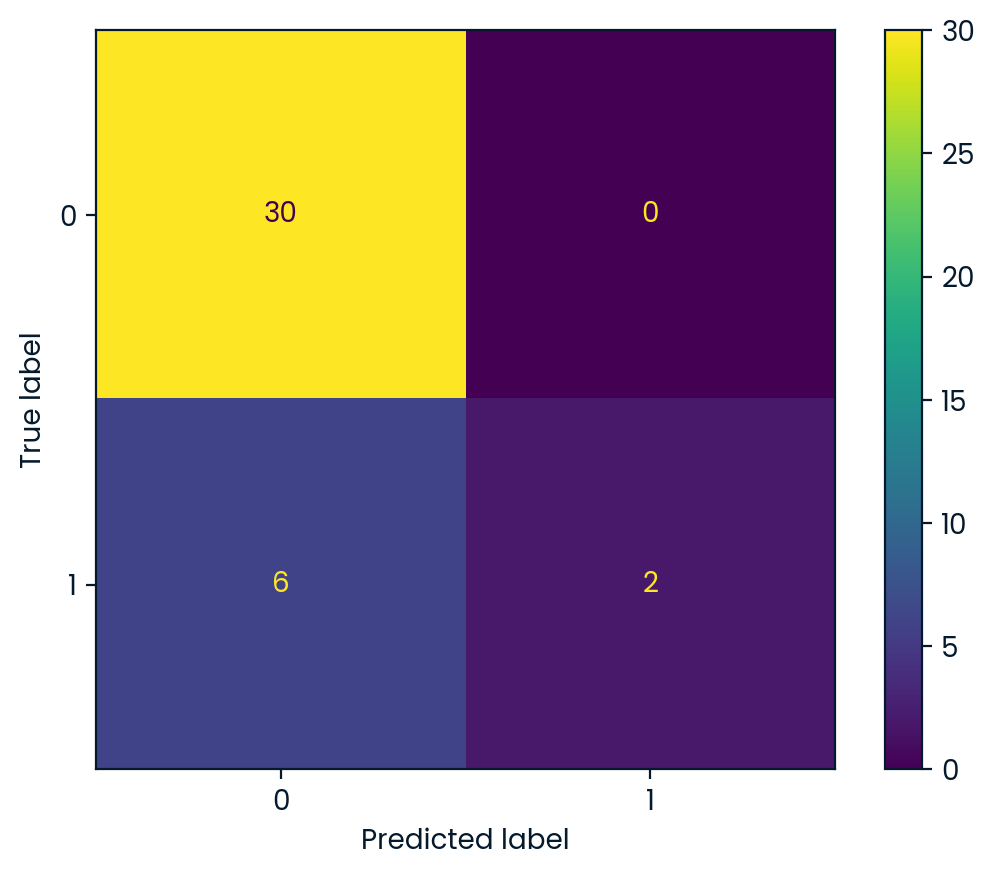

In [63]:
# best model
models = {
    'LogisticRegression': grid_lr,
    'KNeighborsClassifier': grid_knn,
    'RandomForestClassifier': grid_rf
}

best_model_name = 'LogisticRegression'
model = grid_lr
model_results = lr_results

best_model_info = model.best_params_
best_model_cv_score = model.best_score_
accuracy = model_results[0]
precision = model_results[1]
recall = model_results[2]
f1 = model_results[3]

# Libs
from sklearn.metrics import ConfusionMatrixDisplay

# visualizing the confusion matrix for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=model_results[4],
                              display_labels=model.best_estimator_.estimator.classes_)
disp.plot()
plt.show()